# AOTY 2022 Spotify Analysis
For some extra fun this year, I decided to do some analysis with Spotify data. This shouldn't be run until after the AOTY notebook has been run.

In [1]:
from datetime import datetime
import json
from pathlib import Path
from textwrap import wrap

import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import plot_styles
import seaborn as sns
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
plt.style.use('spotify')

# Set up font
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Geomanist'
plt.rcParams['font.weight'] = 'regular'

In [3]:
now = datetime.now().strftime('%Y-%m-%d')
now

'2024-01-01'

In [4]:
data_cache = Path('Data Cache')
data_cache.mkdir(exist_ok=True)

graph_dir = Path('Graphs')
graph_dir.mkdir(exist_ok=True)

In [5]:
def make_radar_chart(data, color, plot_cols, label=None, line_kws=None, fill_kws=None):
    line_kws = line_kws or dict(linewidth=2)
    line_fmt = line_kws.pop('fmt', 'o-')
    
    fill_kws = fill_kws or dict(alpha=0.25)
    
    ax = plt.gca()
    
    lc = line_kws.pop('c', None) or line_kws.pop('color', color)
    fc = fill_kws.pop('c', None) or fill_kws.pop('color', color)
    
    labels = np.array(plot_cols)
    for i, row in data.iterrows():
        values = row[plot_cols].tolist()
        values = np.concatenate((values, [values[0]]))

        angles = np.linspace(0, 2*np.pi, len(plot_cols), endpoint=False)
        angles = np.concatenate((angles, [angles[0]]))
        
        ax.plot(angles, values, line_fmt, c=lc, **line_kws)
        ax.fill(angles, values, c=fc, **fill_kws)
        
    ax.set_thetagrids(angles[:-1] * 180/np.pi, labels)
    ax.spines["polar"].set_visible(False)
    
    ax.tick_params(pad=.1)
    
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticklabels([])
    
    ax.grid(True, alpha=.4)

In [6]:
auth = spotipy.SpotifyOAuth(
    redirect_uri='http://localhost:8889/callback', username='valeadam'
)

sp = spotipy.Spotify(auth_manager=auth)

In [7]:
albums={
    1: ('the record', 'boygenius'), 
    2: ('desire, i want to turn into you', 'caroline polachek'), 
    3: ('rat saw god', 'wednesday'), 
    4: ('heavy heavy', 'young fathers'),
    5: ('madres', 'sofia kourtesis'), 
    6: ('maps', 'billy woods'), 
    7: ('raven', 'kelela'),
    8: ('javelin', 'sufjan stevens'), 
    9: ('this is why', 'paramore'),
    10: ('again', 'oneohtrix point never'), 
    11: ('praise a lord', 'yves tumor'), 
    12: ('my back was a bridge', 'anohni the johnsons'), 
    13: ('false lankum', 'lankum'),
    14: ('i am not there anymore', 'the clientele'), 
    15: ('cartwheel', 'hotline tnt'), 
    16: ('famous last words', 'casisdead'), 
    17: ('all fiction', 'pile'),
    18: ('spencer cullum\'s coin collection', 'spencer cullum'), 
    19: ('soft hell', 'closure in moscow'), 
    20: ('the age of pleasure', 'janelle monae')
}

In [8]:
frames = []

for rank, (album, artist) in albums.items():
    file_path = data_cache / f'{album}_{artist}.json'
    
    # Get / load the main info for the album
    if file_path.is_file():
        alb_obj = json.load(file_path.open())
    else:
        search_results = sp.search(f'{album} artist:{artist}', type='album', market='GB')
        
        alb_obj = sp.album(search_results['albums']['items'][0]['id'])
        json.dump(alb_obj, file_path.open('w'))
    
    # Simplified names for plotting etc
    album_name = alb_obj['name']
    artists = ', '.join(artist['name'] for artist in alb_obj['artists'])
    
    # We need to pull out the tracks in order to get the audio features
    tracks = alb_obj['tracks']['items']
    
    # Get track info - this inclues popularity!
    info_file = file_path.with_name(file_path.stem + '_info' + file_path.suffix)
    if info_file.is_file():
        track_info = json.load(info_file.open())
    else:
        track_info = sp.tracks([t['id'] for t in tracks])['tracks']
        json.dump(track_info, info_file.open('w'))
    
    # Get audio features
    feat_file = file_path.with_name(file_path.stem + '_features' + file_path.suffix)
    if feat_file.is_file():
        audio_features = json.load(feat_file.open())
    else:
        audio_features = sp.audio_features([t['id'] for t in tracks])
        json.dump(audio_features, feat_file.open('w'))
    
    # Drop empty features 
    audio_features = [a for a in audio_features if a]
    
    title_wrapped = wrap(album_name, 20)
    if len(title_wrapped) > 2:
        title_wrapped[1] += '...'
    title_wrapped = title_wrapped[:2]
    
    
    merged = pd.DataFrame(tracks)\
               .merge(pd.DataFrame(track_info), on='id', how='left')\
               .merge(pd.DataFrame(audio_features), on='id', how='left')\
               .assign(Rank=rank, Album='\n'.join(title_wrapped), Artists=artists)
    
    frames.append(merged)

data = pd.concat(frames, ignore_index=True)

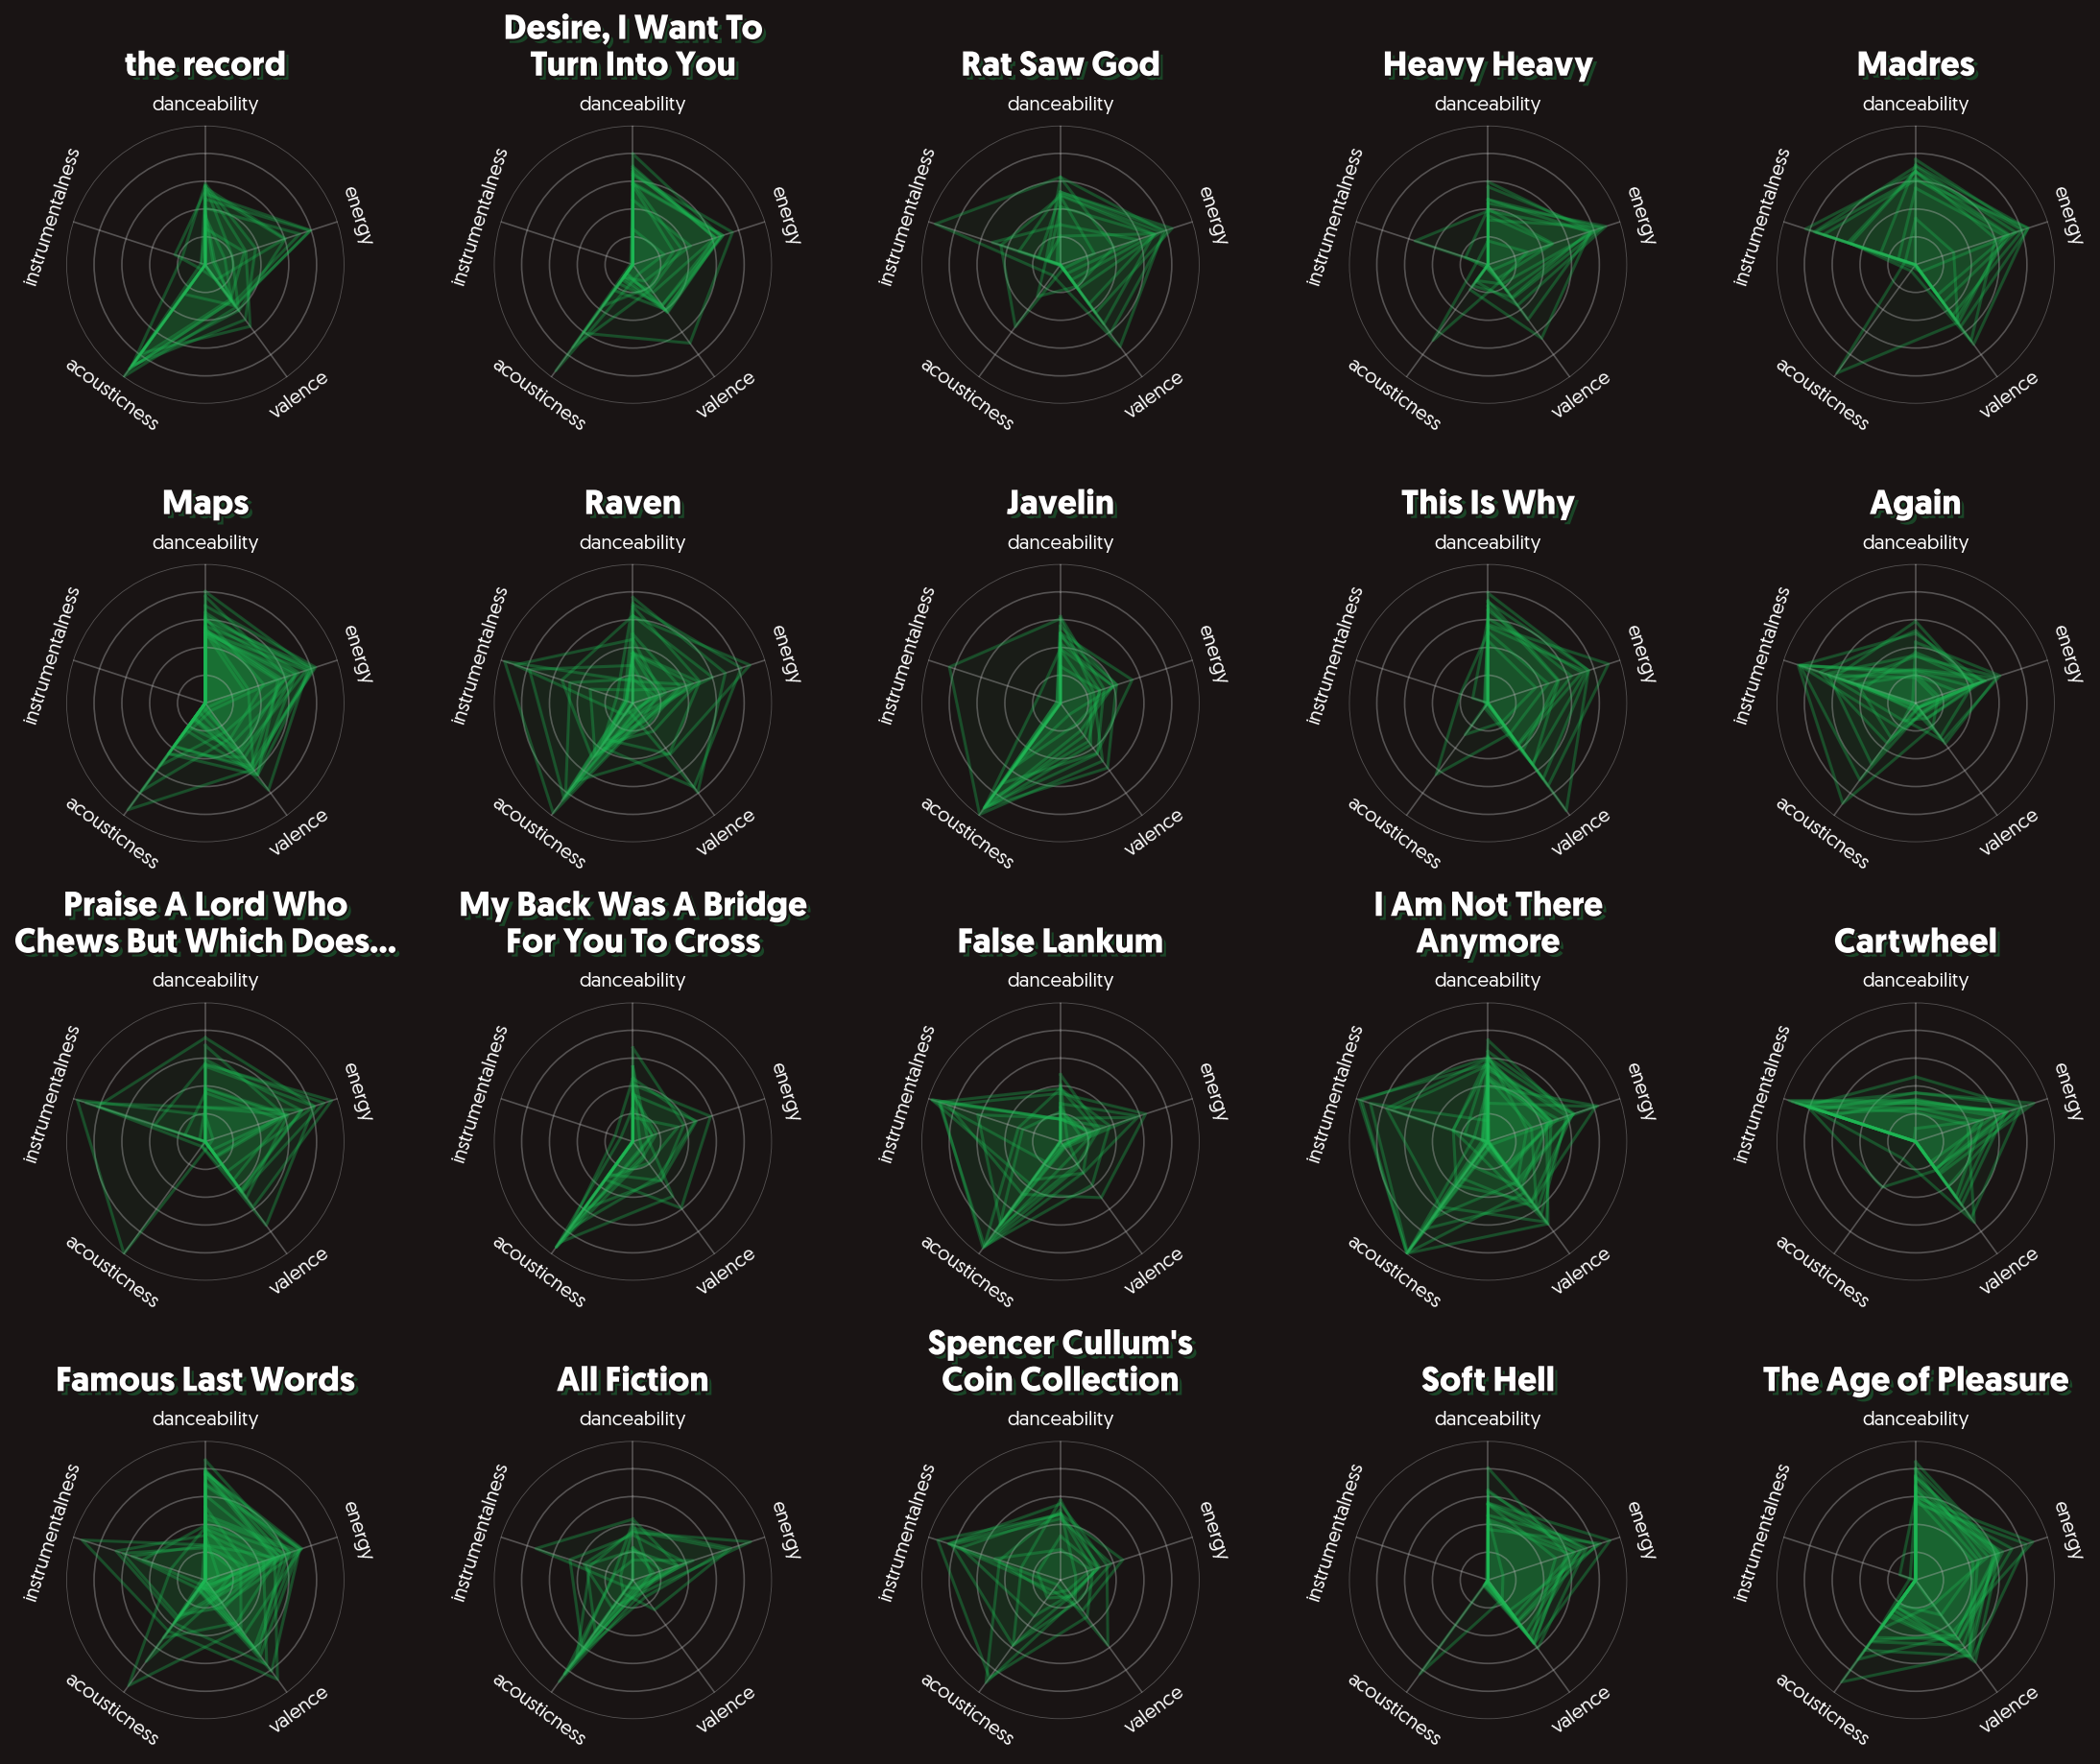

In [9]:
g = sns.FacetGrid(data=data, col='Album', subplot_kws=dict(projection='polar'), despine=False, col_wrap=5, sharex=False, sharey=False)

line_kws = {
    'fmt': '-', 'ms': 0, 'alpha':.3
}

fill_kws = {
    'alpha': 0.05
}

g.map_dataframe(
    make_radar_chart, 
    plot_cols=['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness'], 
    line_kws=line_kws, fill_kws=fill_kws
)

# # Rotate "spoke" labels
plt.gcf().canvas.draw()
for ax in g.axes.ravel():
    ax.set_ylim(0,1)
    angles = np.linspace(0,2*np.pi,len(ax.get_xticklabels())+1)
    angles[np.cos(angles) < 0] = angles[np.cos(angles) < 0] + np.pi
    angles = np.rad2deg(angles)
    labels = []
    for label, angle in zip(ax.get_xticklabels(), angles[::-1]):
        x,y = label.get_position()
        lab = ax.text(x,y, label.get_text(), transform=label.get_transform(),
                      ha=label.get_ha(), va=label.get_va())
        lab.set_rotation(angle)
        labels.append(lab)
    ax.set_xticklabels([])
    
    ax.title.set_path_effects([
        pe.SimplePatchShadow(shadow_rgbFace='C0'), 
        pe.Stroke(foreground=plt.rcParams['figure.facecolor'], linewidth=2),
        pe.Normal()
    ])

g.set_titles('{col_name}', weight='bold', size='xx-large', pad=25)
g.fig.subplots_adjust(hspace=.5)
plt.savefig(graph_dir / '10 Album Radars.png', bbox_inches='tight')

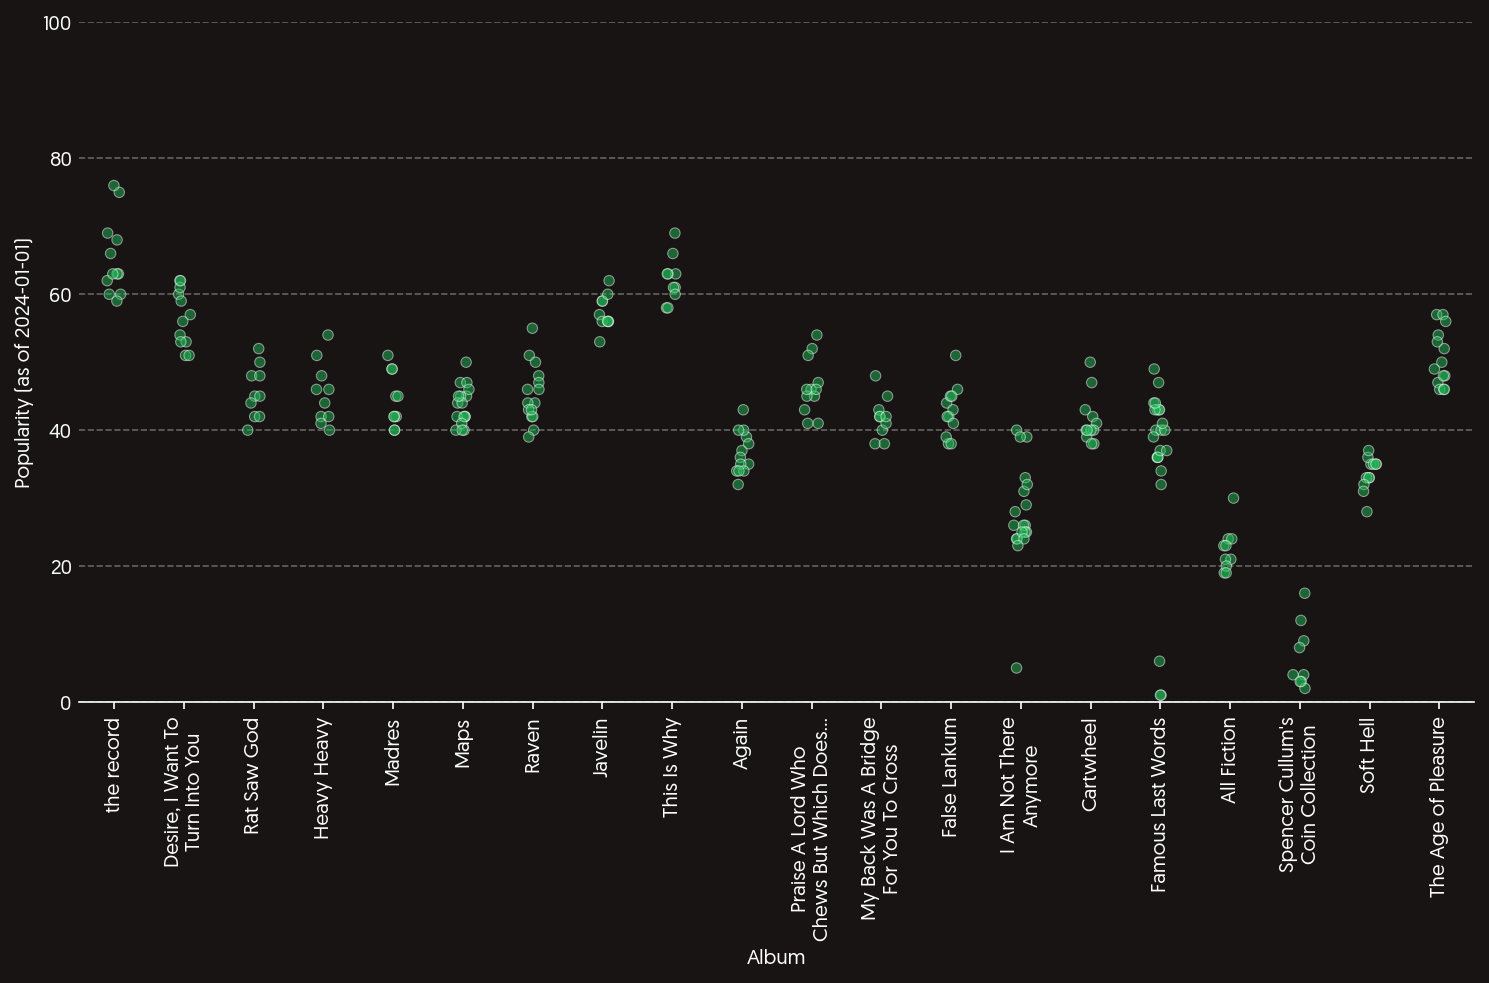

In [10]:
fig, ax = plt.subplots(figsize=(12,6))

ax.grid(axis='both', ls='--', alpha=.5)
ax.set_ylim(top=100)
ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', length=0)

ax.tick_params(axis='x', labelrotation=90)

sns.stripplot(data=data, x='Album', y='popularity', ax=ax, color='C0', s=5, ec='white', linewidth=.5, alpha=0.5)

ax.set_ylabel(f'Popularity (as of {now})')
plt.savefig(graph_dir / '11 Popularity.png', bbox_inches='tight')